In [91]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, ImageCollection
import cv2
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import fastai
from fastai.vision.all import *
import albumentations as A
from albumentations import ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
from PIL import Image
import seaborn as sns
import collections

## Loading and Exploration

In [2]:
# Create the ImageCollection object
skimage_collection = ImageCollection('/Users/maxwellkreitman/Desktop/CV_flower_project/pics/*.jpg', load_func=imread, conserve_memory=False, plugin='matplotlib')

# Print the number of images loaded
print(f"Number of images loaded: {len(skimage_collection)}")

Number of images loaded: 8189


In [3]:
#loading imagelabels.mat MATLAB file
mat_labels = loadmat('imagelabels.mat')

In [4]:
print(mat_labels.keys())

dict_keys(['__header__', '__version__', '__globals__', 'labels'])


In [5]:
labels = mat_labels['labels'].tolist()
label_list = []
label_list.extend(labels[0])


In [85]:
#creating dataframe from mat_labels
df = pd.DataFrame({"flower_id" : list(range(1,8190)), "label_id" : mat_labels['labels'][0]})

In [86]:
#compiled list of English labels from 
NAMES = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "english marigold",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia?",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen",
    "watercress",
    "canna lily",
    "hippeastrum",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
]

In [89]:
df["class"] = df['label_id'].map(lambda x: NAMES[x-1])

In [90]:
df.head()

flower_id  label_id           Class           class
0          1        77  passion flower  passion flower
1          2        77  passion flower  passion flower
2          3        77  passion flower  passion flower
3          4        77  passion flower  passion flower
4          5        77  passion flower  passion flower

In [10]:
#confirming an equal number of labels to picture files of 8,189
print(f"Number of labels loaded: {len(label_list)}")

Number of labels loaded: 8189


In [11]:
#confirming the list has 102 classes as described in the readme
print(f"Number of classes in data: {len(set(label_list))}")

Number of classes in data: 102


In [12]:
#counting occurance of every class between 1 and 102
pic_counts = Counter(label_list)

In [13]:
print(pic_counts)

Counter({51: 258, 77: 251, 46: 196, 73: 194, 89: 184, 74: 171, 81: 166, 94: 162, 88: 154, 78: 137, 83: 131, 43: 130, 95: 128, 41: 127, 75: 120, 58: 114, 82: 112, 56: 109, 60: 109, 37: 108, 76: 107, 80: 105, 65: 102, 72: 96, 44: 93, 53: 93, 50: 92, 23: 91, 96: 91, 11: 87, 12: 87, 84: 86, 8: 85, 30: 85, 17: 85, 52: 85, 18: 82, 90: 82, 98: 82, 29: 78, 71: 78, 91: 76, 36: 75, 48: 71, 55: 71, 40: 67, 47: 67, 59: 67, 57: 67, 92: 66, 28: 66, 97: 66, 5: 65, 85: 63, 87: 63, 99: 63, 70: 62, 54: 61, 66: 61, 2: 60, 22: 59, 42: 59, 86: 58, 101: 58, 20: 56, 4: 56, 38: 56, 62: 55, 63: 54, 68: 54, 69: 54, 64: 52, 31: 52, 61: 50, 13: 49, 19: 49, 49: 49, 15: 49, 100: 49, 14: 48, 102: 48, 93: 46, 9: 46, 33: 46, 32: 45, 10: 45, 6: 45, 35: 43, 24: 42, 67: 42, 26: 41, 25: 41, 16: 41, 79: 41, 39: 41, 3: 40, 1: 40, 21: 40, 27: 40, 34: 40, 45: 40, 7: 40})


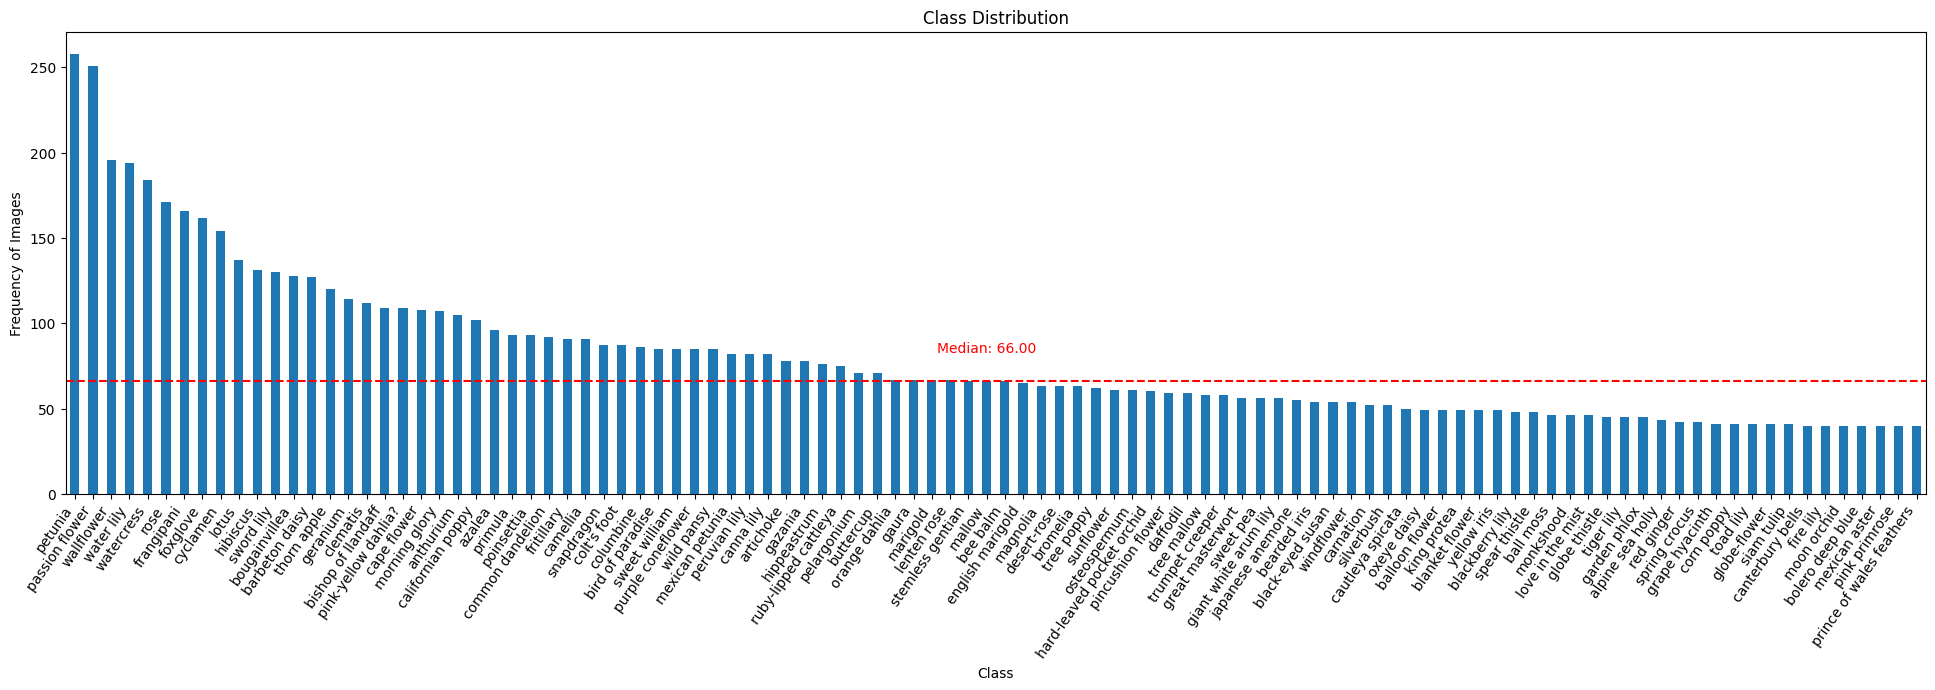

In [14]:
median_value = np.median(df['Class'].value_counts())
#visualizing the distribution over all classes
class_counts = df['Class'].value_counts()
plt.figure(figsize=(24, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency of Images')
plt.title('Class Distribution')
plt.axhline(y=median_value, color='red', linestyle='--', label='Average Frequency')
plt.text(50, median_value + 15, f'Median: {median_value:.2f}', color='red', ha='center', va='bottom')
plt.xticks(rotation=55, ha='right')
plt.show()

##### Class imbalance seems to be an issue here.  I plan to use weighted loss during dataloader step.

In [15]:
# Calculating class weights
total_samples = sum(pic_counts.values())
class_weights = [total_samples / (len(pic_counts) * pic_counts[class_i]) for class_i in pic_counts.keys()]

total_weight = sum(class_weights)
#normalizing class weights
class_weights_normalized = [weight / total_weight for weight in class_weights]

In [16]:
#minimum frequency of images over all class labels
print(f"Minimum value in the dictionary of labels: {min(pic_counts.values())}")
print(f"Maximum value in the dictionary of labels: {max(pic_counts.values())}")

Minimum value in the dictionary of labels: 40
Maximum value in the dictionary of labels: 258


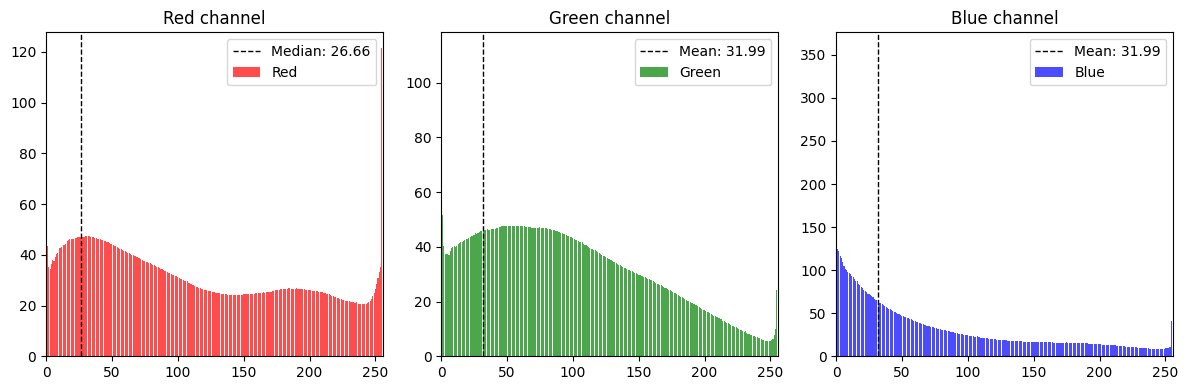

In [17]:
# Initializing arrays to hold all pixel histograms of each channel
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

# Iterate through each image in the collection
for img in skimage_collection:

    # Split the image into its respective channels
    r, g, b = cv2.split(img)
    
    # Compute histogram for each channel and accumulate
    hist_r += np.histogram(r, bins=256, range=[0,256], density=True)[0]
    hist_g += np.histogram(g, bins=256, range=[0,256], density=True)[0]
    hist_b += np.histogram(b, bins=256, range=[0,256], density=True)[0]

#Median & mean calculations
median_r = np.median(hist_r)
mean_g = np.mean(hist_g)
mean_b = np.mean(hist_b)
    
# Prepare bins for histogram
bins = np.arange(256)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram for Red channel
axs[0].bar(bins, hist_r, color='red', alpha=0.7, label='Red')
axs[0].set_title('Red channel')
axs[0].set_xlim([0,256])
axs[0].axvline(median_r, color='k', linestyle='dashed', linewidth=1, label=f'Median: {median_r:.2f}')
axs[0].legend()

# Plot histogram for Green channel
axs[1].bar(bins, hist_g, color='green', alpha=0.7, label='Green')
axs[1].set_title('Green channel')
axs[1].set_xlim([0,256])
axs[1].axvline(mean_g, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_g:.2f}')
axs[1].legend()

# Plot histogram for Blue channel
axs[2].bar(bins, hist_b, color='blue', alpha=0.7, label='Blue')
axs[2].set_title('Blue channel')
axs[2].set_xlim([0,256])
axs[2].axvline(mean_b, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_b:.2f}')
axs[2].legend()

# Add legend
for ax in axs:
    ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### The spike at 255 in the Red channel indicates some outlier data and I decided the median would be a better center to the distribution, while mean suited the Green channel and Blue channel centers of distribution.

### Both red and green channel have right-skew shape.

### Spot checking 4 images belonging to the first 4 classes

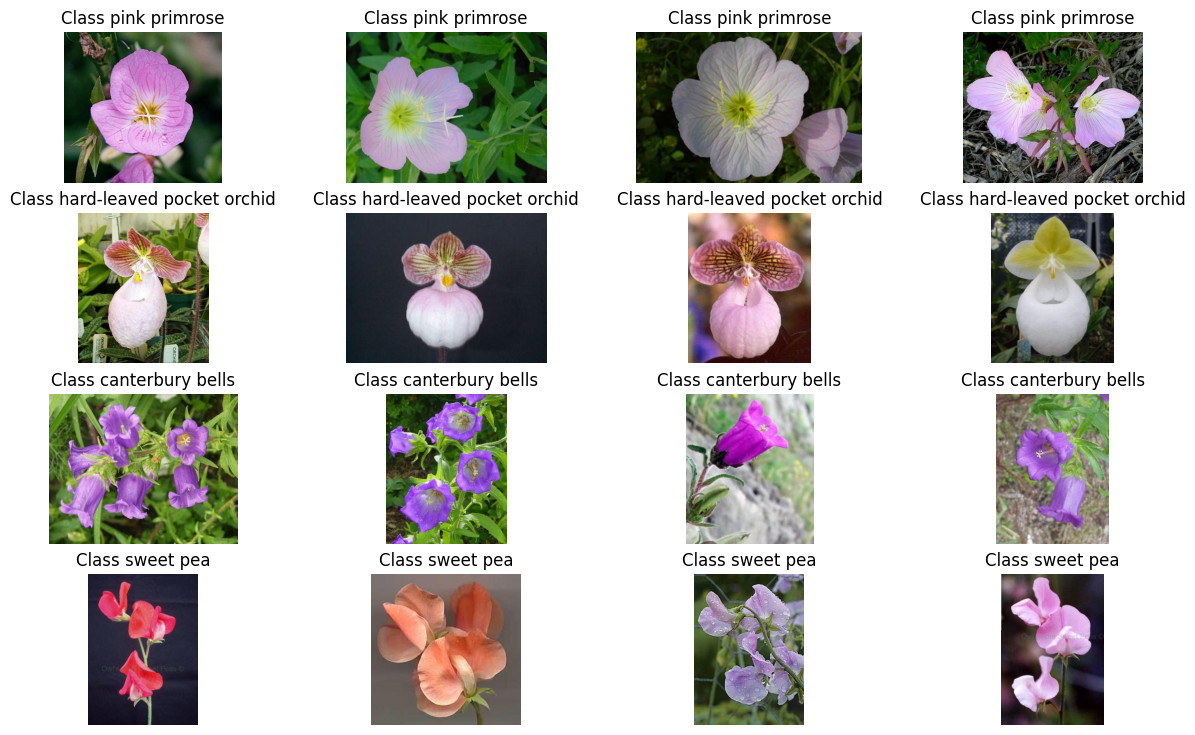

In [18]:
#determining image index group belonging to each class
label_1_indices = np.where(np.array(label_list) == 1)[0][:4]
label_2_indices = np.where(np.array(label_list) == 2)[0][:4]
label_3_indices = np.where(np.array(label_list) == 3)[0][:4]
label_4_indices = np.where(np.array(label_list) == 4)[0][:4]

#plotting images
fig, axes = plt.subplots(4, 4, figsize=(15, 9))

for i, indices in enumerate([label_1_indices, label_2_indices, label_3_indices, label_4_indices]):
    for j, index in enumerate(indices):
        image = skimage_collection[index]
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'Class {df.iloc[index]["Class"]}')
        axes[i, j].axis('off')

plt.show()

### Shape and pattern of the flower can vary between pictures of the same class.  There are many instances of complex backgrounds and color variations as well.

### Now I want to visualize the distribution of image dimensions in my data.

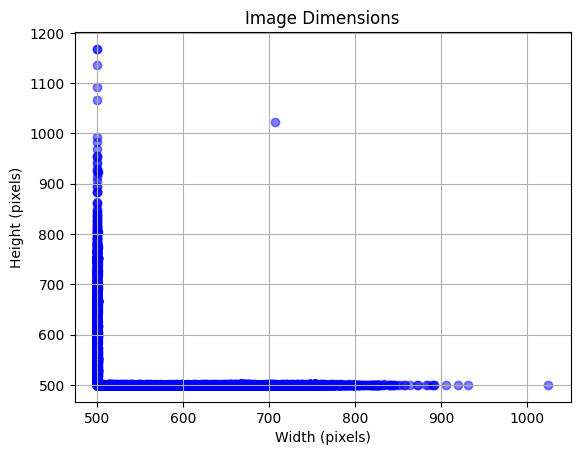

In [19]:
#creating a list of tuples that hold the shape (width and height) of each image
image_dimensions = [(image.shape[1], image.shape[0]) for image in skimage_collection]
#unzipping image_dimensions 
widths, heights = zip(*image_dimensions)
#building a scatter plot
plt.scatter(widths, heights, marker='o', color='blue', alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

### While there are a few outliers, the rest seem to be reasonably similar in size.

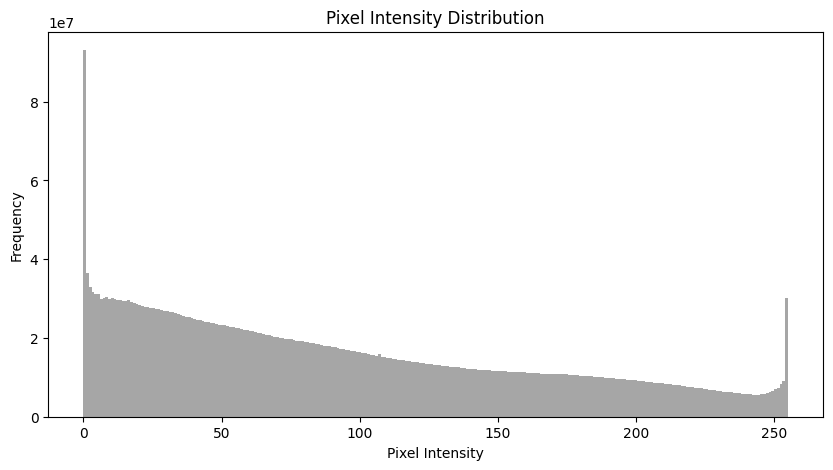

In [20]:
#exploring pixel intensity on the first half the images

# Specify the path to the directory containing your images
images_directory = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/"
all_image_paths = glob.glob(images_directory + "*.jpg")  

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[:split_index]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

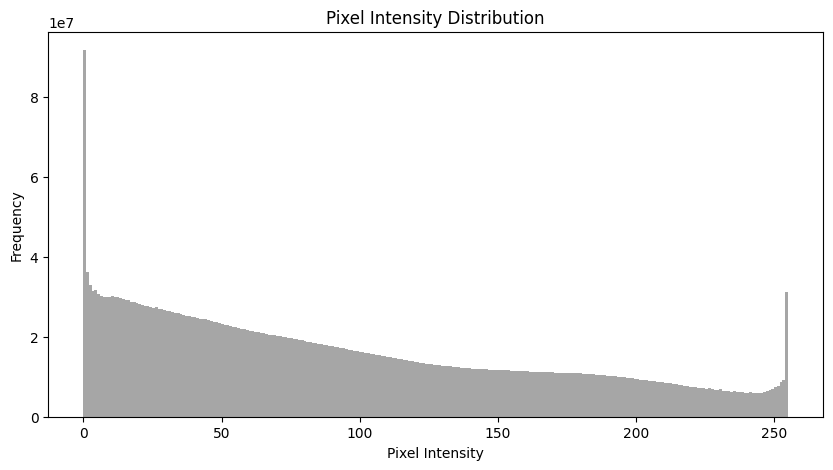

In [31]:
#exploring pixel intensity on second half the images

# Specify the path to the directory containing your images
images_directory = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/"
all_image_paths = glob.glob(images_directory + "*.jpg")  

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[split_index:]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

### Both graphs show a negative linear relationship and no aparent peak. There are outlier spikes at left and righthand sides.

In [22]:
#loading image files into folder called images
images = get_image_files("/Users/maxwellkreitman/Desktop/CV_flower_project/pics")


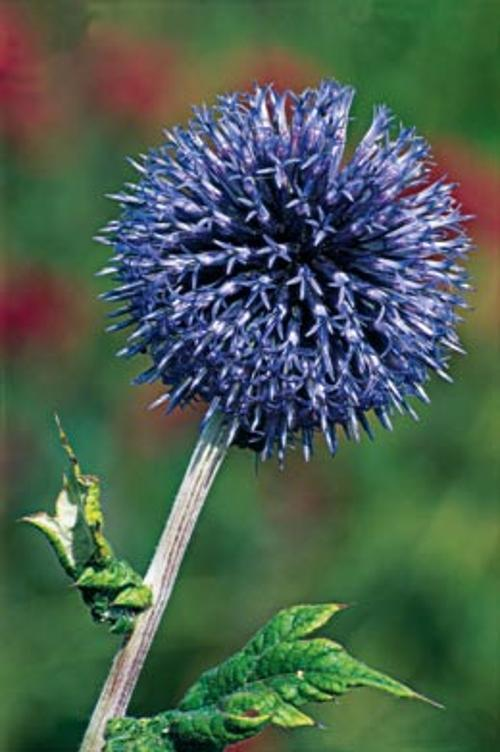

In [23]:
img = PILImage.create(images[0])
img

Problem!  This flower is not the passion flower from img_00001.jpg.  The get_images_files sorting method is messing up the order of flowers.

In [24]:
# Sorting images based on filename sequence in dataset
def custom_sort(file_path):
    # Extract numeric part from the file name (assuming it ends with a number)
    return int(''.join(filter(str.isdigit, file_path.stem)))

# Sort the images based on the custom sorting function
images = sorted(images, key=custom_sort)

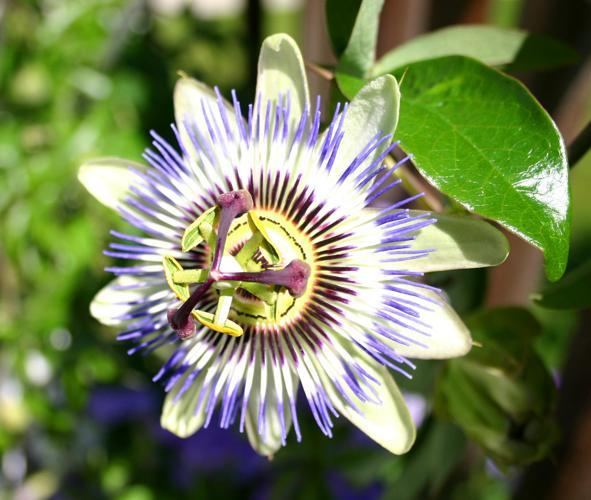

In [25]:
img = PILImage.create(images[0])
img

#### Fixed!  This is a passion flower from image_00001.jpg, the first one in the data set.

In [26]:
class_list = df['class'].tolist()

train_images, test_images = train_test_split(images, test_size=0.1, random_state=25)
train_label_list, test_label_list = train_test_split(class_list, test_size=0.1, random_state=25)


In [27]:
#creating two dataloaders for train and test sets and attaching labels, resizing to 224 pixels, 
#normalizing using precomputed statistics from ImageNet,
#and using normalized class weights calculated earlier to address class imbalance

train_dls = ImageDataLoaders.from_lists(
    "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
    fnames=train_images,
    labels=train_label_list,
    valid_pct=0.2,
    item_tfms=Resize(128),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    class_weights=class_weights_normalized
)

test_dls = ImageDataLoaders.from_lists(
    "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
    fnames=test_images,
    labels=test_label_list,
    valid_pct=0.2,
    item_tfms=Resize(128),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    class_weights=class_weights_normalized
)

In [28]:
# Checking to see that all classes are represented in training and test dataloaders

if train_dls.vocab == test_dls.vocab:
    print("All classes are represented in training and test dataloaders.")
else:
    print("Try another random_state.")

All classes are represented in training and test dataloaders.


### Some examples of pictures from the training image data loader:

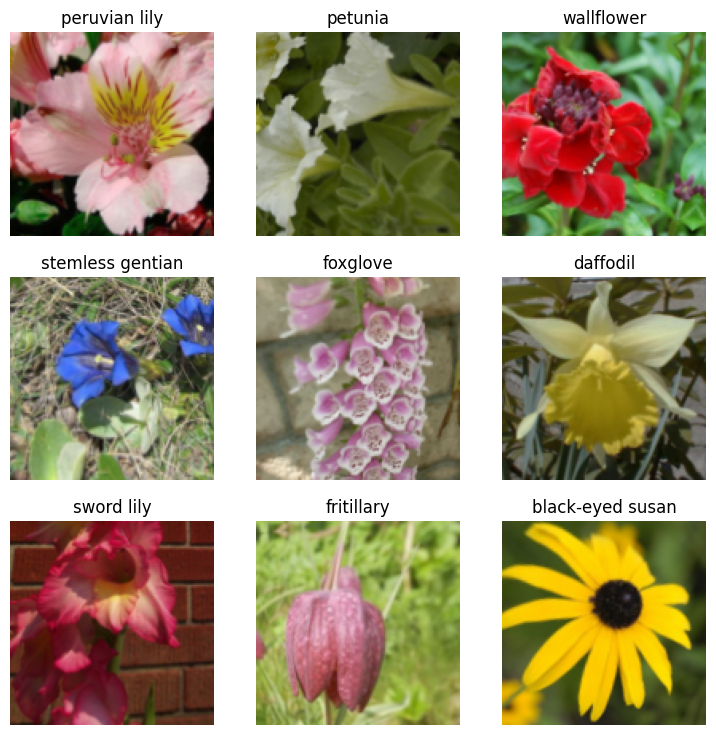

In [29]:
train_dls.show_batch()

## Modeling

In [30]:
#creating the CV model using pre-trained resnet50
cv_learn = vision_learner(train_dls, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0010000000474974513)

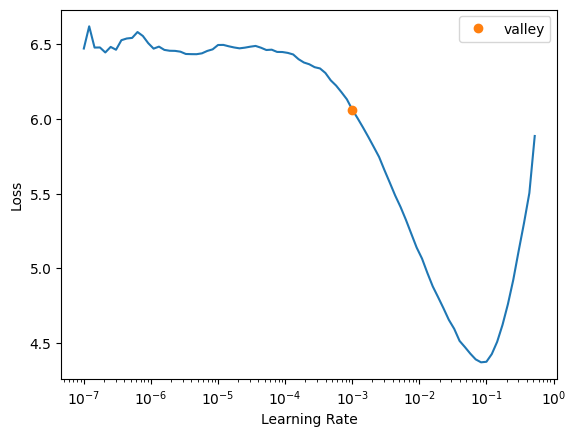

In [32]:
#finding optimal learning rate
cv_learn.lr_find()

In [33]:
# training the model
cv_learn.fit_one_cycle(5, lr_max= 1e-3)

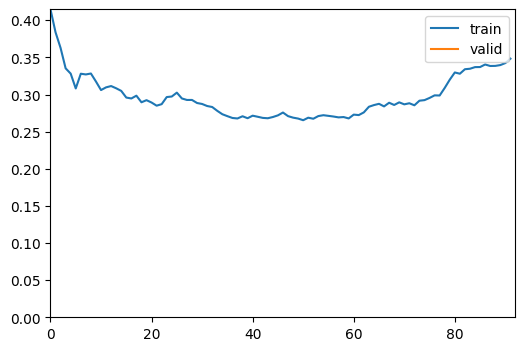

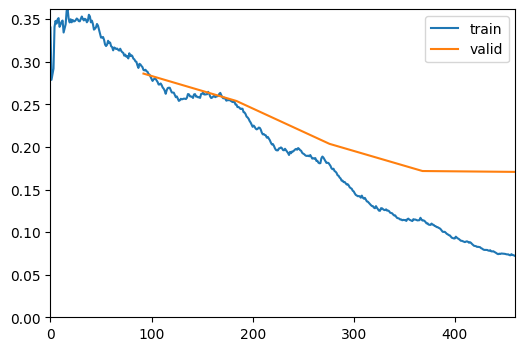

In [35]:
#tuning hyperparameters
cv_learn.fine_tune(5, 1e-3, cbs=ShowGraphCallback())

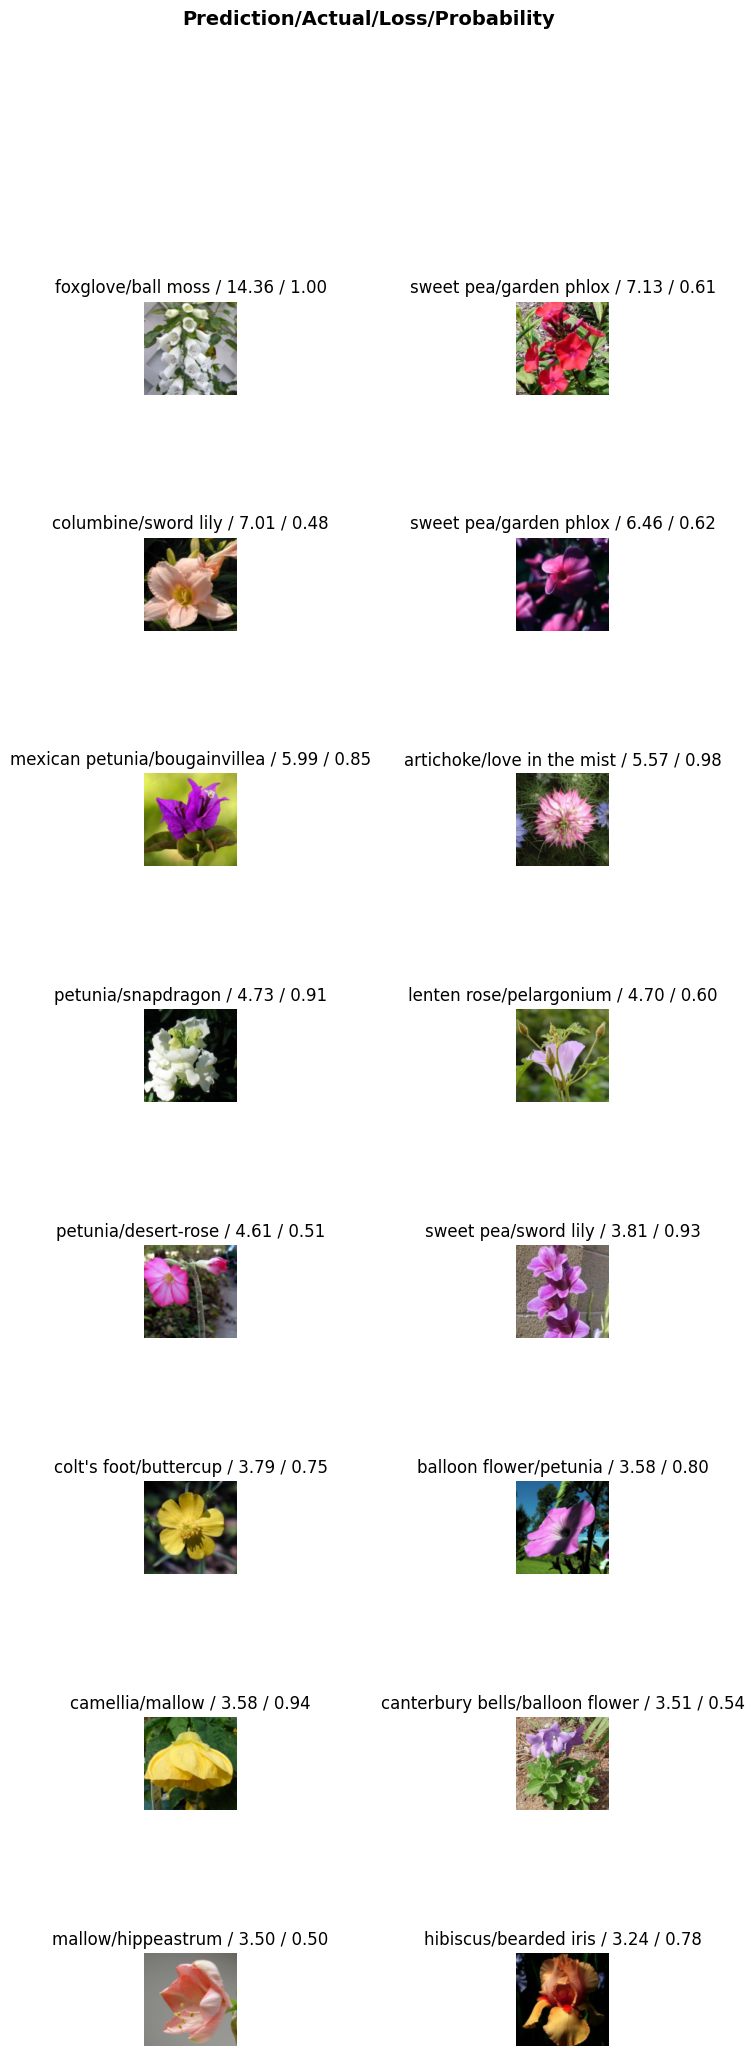

In [129]:
interp.plot_top_losses(k=16, nrows=8)
plt.subplots_adjust(wspace=3)
plt.show()

In [171]:
#I want to count the number of wrongly predicted flowers per class

top_losses, top_loss_indices = interp.top_losses()

print("Total erroneous predictions: "+ str(len(top_loss_indices)))
print(top_loss_indices[:50])

Total erroneous predictions: 1474
TensorBase([ 174, 1333, 1420, 1083,  983,  642, 1322, 1340, 1233,  173, 1444,  743,
        1047,  878,  264,  917, 1020,  198,  952, 1428,  960, 1407,  504,  768,
        1208, 1149,  259, 1067, 1275,  575,  383, 1027,  656,  729,  549,  228,
        1051, 1116,  445,  860,  225,  468,  841, 1320,  558,  706,  913, 1077,
         826,   22])


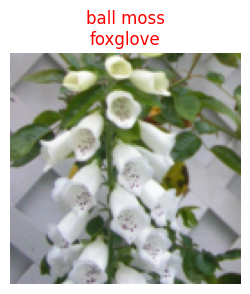

In [172]:
#for upclose viewing
interp.show_results(174)

In [169]:
#counting instances of wrongly predicted flowers
top_loss_labels = [train_dls.valid_ds.items[i][1] for i in top_loss_indices]
label_counts = Counter(top_loss_labels)
print(label_counts)

Counter({'passion flower': 46, 'petunia': 44, 'rose': 40, 'wallflower': 34, 'watercress': 33, 'water lily': 32, 'bougainvillea': 29, 'foxglove': 29, 'cape flower': 27, 'lotus': 26, 'frangipani': 26, 'anthurium': 26, 'cyclamen': 24, 'sword lily': 22, 'columbine': 21, 'barbeton daisy': 21, 'thorn apple': 21, 'geranium': 21, 'hibiscus': 20, 'snapdragon': 19, 'peruvian lily': 19, 'pelargonium': 18, 'buttercup': 18, 'canna lily': 18, 'primula': 18, 'bishop of llandaff': 18, 'marigold': 18, 'pink-yellow dahlia?': 18, 'desert-rose': 17, 'bird of paradise': 17, 'californian poppy': 17, 'morning glory': 16, 'bee balm': 16, 'clematis': 16, 'sweet william': 16, "colt's foot": 16, 'poinsettia': 16, 'mallow': 14, 'lenten rose': 14, 'oxeye daisy': 14, 'bromelia': 14, 'ball moss': 13, 'tree mallow': 13, 'silverbush': 13, 'fritillary': 13, 'garden phlox': 12, 'hippeastrum': 12, 'bearded iris': 12, 'camellia': 12, 'english marigold': 12, 'ruby-lipped cattleya': 12, 'stemless gentian': 12, 'wild pansy':

In [174]:
print("Ball moss was predicted as a different flower "+ str(label_counts['ball moss'])+" times.")

Ball moss was predicted as a different flower 13 times.


In [147]:

#cv_learn.export('/Users/maxwellkreitman/Desktop/CV_flower_project/pics/models/CVmodel_fastai_resnet50.pkl')
